In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import truncnorm, uniform
from statsmodels.tsa.api import VAR
import sys
from tqdm.auto import tqdm

sys.path.append('../../..')
from multiproc_VAR_p_grid_search import compute_VAR_p, predict_VAR_p
from nld_utils import simulate_baier_klein, simulate_double_pendulum, simulate_lorenz, simulate_rossler

# Set up Dynamics

In [23]:
N = 512
# T = 50 # s
# T *= 1000 # ms
dt = 1 # ms
# g = np.linspace(0.8, 1.6, int(T/dt))
# g = np.hstack([[0.9]*2500, [1]*2500, [1.1]*10000, [1.2]*10000, [1.3]*10000, [1.4]*10000, [1.5]*5000])
g_vals = np.hstack([[0.9], np.arange(0.98, 1.4, 0.01)])
g_durations = [10000]*len(g_vals)

g = np.hstack([[val]*duration for val, duration in zip(g_vals, g_durations)])
T = np.sum(g_durations)

tau = 100 # ms
W = np.random.randn(N, N)

x = np.zeros((int(T/dt), N))
x[0] = np.random.randn(N)*0.01

for t in tqdm(range(1, int(T/dt))):
    x[t] = x[t-1] + (dt/tau)*(-x[t-1] + (g[t]/np.sqrt(N))*W@np.tanh(x[t-1]))

  0%|          | 0/429999 [00:00<?, ?it/s]

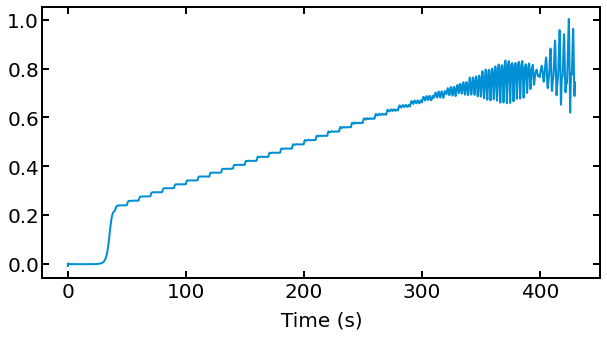

In [24]:
plt.plot(np.arange(x.shape[0])/dt*0.001, x[:, 0])
plt.xlabel('Time (s)')
plt.show()

# VAR Grid Search

In [25]:
d = 25
indices = np.random.choice(N, size=(d,), replace=False)
data = x[:, indices]
dt = 0.001

In [26]:
windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.1, 0.5)]
# windows = np.hstack([np.arange(0.05, 0.101, 0.01), [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]])
# windows = [0.25, 0.5, 0.75, 1, 2, 3, 4, 5]
max_lag = 15
lags = np.arange(1, max_lag + 1)
T_pred = 25
num_window_samples = 10

In [27]:
grid_search_df = []
iterator = tqdm(total = len(windows)*len(lags))
for window in windows:
    stride = window
    min_ind = int(0/stride)
    max_ind = int((data.shape[0]*dt - window - T_pred*dt)/stride)
    possible_inds = np.arange(min_ind, max_ind + 1)
    window_inds = np.random.choice(possible_inds, size=(np.min([num_window_samples, len(possible_inds)])), replace=False)
#     num_windows = int(np.floor((data.shape[0]-window)/stride)+1)
    for p in lags:
#         for i in range(num_windows):
        for i in window_inds:
            start_ind = i*int(stride/dt)
            start_time = i*stride
            end_ind = i*int(stride/dt) + int(window/dt)
            end_time = i*stride + window
            if end_ind + T_pred <= data.shape[0]:
                
                window_data = data[start_ind:end_ind]
                results = compute_VAR_p(window_data, p)
                test_data = data[end_ind - p:end_ind + T_pred]

                train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
                train_mse = ((train_prediction - train_true_vals)**2).mean()
                test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
#                 print(test_prediction.shape)
                test_mse = ((test_prediction - test_true_vals)**2).mean()
                persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

                # ADD TO DICTIONARY
                results['train_mse'] = train_mse
                results['test_mse'] = test_mse
                results['persistence_baseline'] = persistence_baseline

                # ADD TIMESTAMPS
                results['start_ind'] = start_ind
                results['end_ind'] = end_ind
                results['start_time'] = start_time
                results['end_time'] = end_time

                # ADD PARAMETERS
                results['window'] = window
                results['stride'] = stride
                results['p'] = p
                results['T_pred'] = T_pred
                
                grid_search_df.append(results)
        iterator.update()
iterator.close()
grid_search_df = pd.DataFrame(grid_search_df)

  0%|          | 0/300 [00:00<?, ?it/s]

In [28]:
test_mse_mat = np.zeros((len(windows), len(lags)))
for i, window in enumerate(windows):
    for j, p in enumerate(lags):
        test_mse_mat[i, j] = grid_search_df[np.logical_and(grid_search_df.window == window, grid_search_df.p == p)].test_mse.mean()

In [29]:
def pick_2d_optimum(mat, thresh=0.95):
    true_min = mat.min()
    i_vals, j_vals = np.where(mat*thresh - true_min <= 0)
    selected_i = np.min(i_vals)
    selected_j = np.min(j_vals[i_vals == selected_i])
    selected_i, selected_j

    return selected_i, selected_j
thresh = 1
w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)

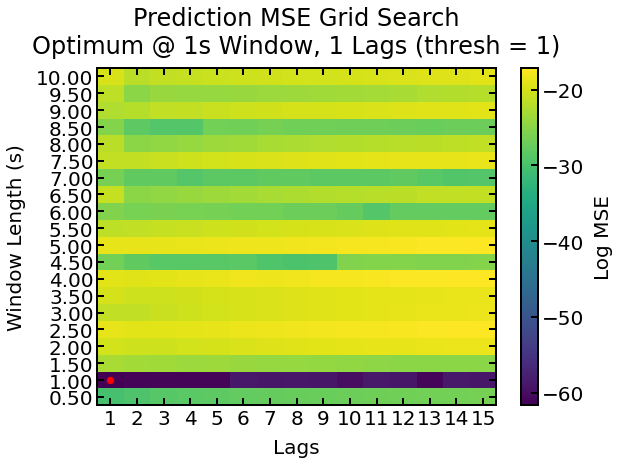

In [30]:
log_test_mse_mat = np.log(test_mse_mat)
plt.style.use('../../sci_style.py')
plt.figure(figsize=(9, 6))
# norm = colors.TwoSlopeNorm(vmin=test_mse_mat.min(), vcenter=test_mse_mat.mean(), vmax=test_mse_mat.max())
# plt.pcolormesh(test_mse_mat, norm=norm)
plt.pcolormesh(log_test_mse_mat)
plt.xticks(np.arange(0, max_lag) + 0.5, [lags[i] for i in np.arange(0, max_lag)])
plt.yticks(np.arange(0, len(windows)) + 0.5, [f"{windows[i]:.2f}" for i in np.arange(0, len(windows))])
plt.xlabel('Lags')
plt.ylabel('Window Length (s)')
cbar = plt.colorbar(label='Log MSE')
# cbar_ticks = [norm.vmin + t*(norm.vcenter-norm.vmin) for t in np.arange(0, 1.1, 0.2)]
# cbar_ticks += [norm.vcenter + t*(norm.vmax-norm.vcenter) for t in np.arange(0, 1.1, 0.2)]
# cbar.set_ticks(cbar_ticks)
plt.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()
plt.title(f"Prediction MSE Grid Search\nOptimum @ {windows[w_ind]}s Window, {lags[p_ind]} Lags (thresh = {thresh})")
plt.show()

# Compute VAR Results

In [32]:
window = windows[w_ind]
p = lags[p_ind]

VAR_results = []
num_windows = int(np.floor((data.shape[0]-int(window/dt))/int(stride/dt)+1))
stride = window
for i in tqdm(range(num_windows)):
    start_ind = i*int(stride/dt)
    start_time = i*stride
    end_ind = i*int(stride/dt) + int(window/dt)
    end_time = i*stride + window
    if end_ind + T_pred <= data.shape[0]:

        window_data = data[start_ind:end_ind]
        results = compute_VAR_p(window_data, p)
        test_data = data[end_ind - p:end_ind + T_pred]

        train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
        train_mse = ((train_prediction - train_true_vals)**2).mean()
        test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
#                 print(test_prediction.shape)
        test_mse = ((test_prediction - test_true_vals)**2).mean()
        persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

        # ADD TO DICTIONARY
        results['train_mse'] = train_mse
        results['test_mse'] = test_mse
        results['persistence_baseline'] = persistence_baseline

        # ADD TIMESTAMPS
        results['start_ind'] = start_ind
        results['end_ind'] = end_ind
        results['start_time'] = start_time
        results['end_time'] = end_time

        # ADD PARAMETERS
        results['window'] = window
        results['stride'] = stride
        results['p'] = p
        results['T_pred'] = T_pred

        VAR_results.append(results)
VAR_results = pd.DataFrame(VAR_results)

  0%|          | 0/430 [00:00<?, ?it/s]

In [33]:
# VAR_results = grid_search_df[np.logical_and(grid_search_df.window == windows[w_ind], grid_search_df.p == lags[p_ind])]

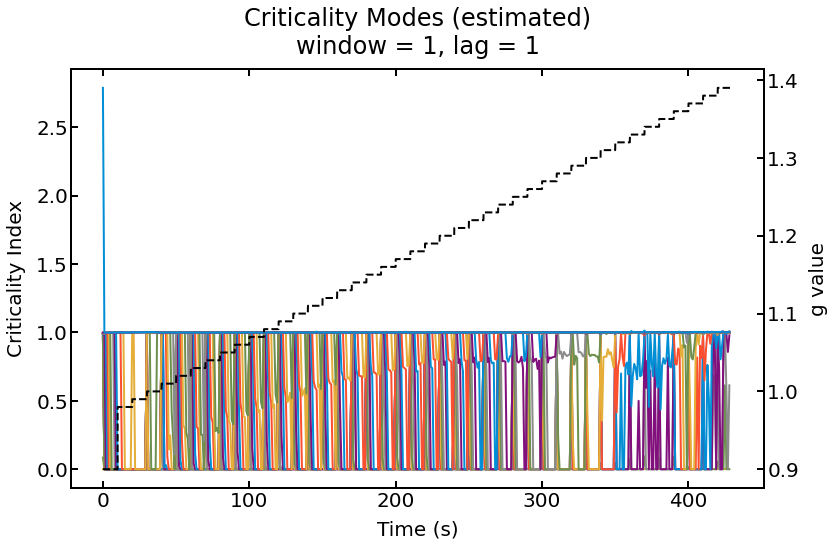

In [34]:
# plot mode criticalities
plt.figure(figsize=(12, 8))
mode_criticalities = np.zeros((len(VAR_results), len(VAR_results.criticality_inds.iloc[0])))
for i, row in VAR_results.iterrows():
    mode_criticalities[i] = np.sort(row.criticality_inds)

for i in range(len(VAR_results.criticality_inds.iloc[0])):
    plt.plot(VAR_results.start_time, mode_criticalities[:, i])
plt.xlabel('Time (s)')
plt.ylabel('Criticality Index')
plt.title(f"Criticality Modes (estimated)\nwindow = {window}, lag = {p}")

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(np.arange(g.shape[0])*0.001, g, label='g value', c='k', linestyle='--')
ax2.set_ylabel('g value')
plt.tight_layout()
plt.show()

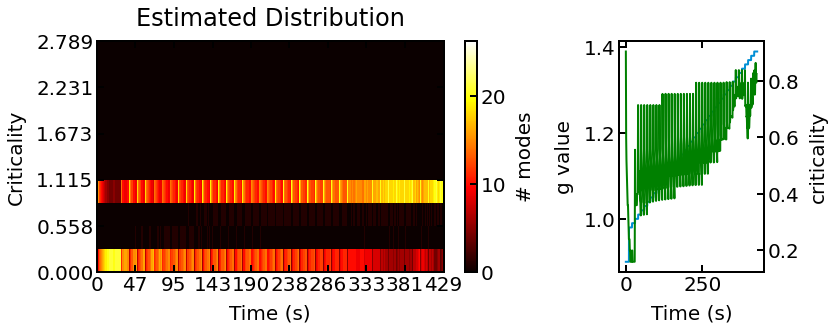

In [35]:
bin_nums = 10
bin_min = np.concatenate(VAR_results.criticality_inds.to_numpy()).min()
bin_max = np.concatenate(VAR_results.criticality_inds.to_numpy()).max()
# bin_max = 1.2
bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
criticality_prob_dist = np.zeros((VAR_results.criticality_inds.shape[0], bin_nums))
for t in range(VAR_results.criticality_inds.shape[0]):
    criticality_prob_dist[t] = np.histogram(VAR_results.criticality_inds[t], bins=bins)[0]
start_times = np.arange(VAR_results.criticality_inds.shape[0])*stride/60
T_max = VAR_results.criticality_inds.shape[0]*stride
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [3, 1]})
ax = axs[0]
im = ax.pcolormesh(criticality_prob_dist.T, cmap='hot', vmin=criticality_prob_dist.min(), vmax=criticality_prob_dist.max()*1.25)
ax.set_xticks([int(i/stride) for i in np.linspace(0, T_max, 10)], [int(i) for i in np.linspace(0, T_max, 10)])
ax.set_yticks(np.arange(0, bin_nums + 1, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 2)]])
cb = fig.colorbar(im, ax=ax)
cb.set_label(label='# modes')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Criticality")
ax.set_title('Estimated Distribution')
ax = axs[1]
ax.plot(np.arange(g.shape[0])*0.001, g, label='g value')
ax.set_ylabel('g value')
ax2 = ax.twinx()
ax2.plot(VAR_results.start_time, VAR_results.criticality_inds.apply(lambda x: x.mean()), label='mean criticality', c='g')
ax2.set_ylabel('criticality')
# ax.legend()
ax.set_xlabel('Time (s)')
# ax.set_title('g value')
plt.tight_layout()
plt.show()